<a href="https://colab.research.google.com/github/olinml2024/notebooks/blob/main/ML24_Assignment10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis of Movie Reviews

In this notebook, you'll be working with the [Stanford Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/).

Here is the most important information from the README file.  Note that there is more information in the README (e.g., on how the files in the dataset are laid out), but this won't be particularly important to us.

# Large Movie Review Dataset v1.0

## Overview

This dataset contains movie reviews along with their associated binary
sentiment polarity labels. It is intended to serve as a benchmark for
sentiment classification. This document outlines how the dataset was
gathered, and how to use the files provided.

## Dataset

The core dataset contains 50,000 reviews split evenly into 25k train and 25k test sets. The overall distribution of labels is balanced (25k pos and 25k neg). We also include an additional 50,000 unlabeled documents for unsupervised learning.

In the entire collection, no more than 30 reviews are allowed for any given movie because reviews for the same movie tend to have correlated ratings. Further, the train and test sets contain a disjoint set of movies, so no significant performance is obtained by memorizing movie-unique terms and their associated with observed labels.  In the labeled train/test sets, a negative review has a score <= 4 out of 10, and a positive review has a score >= 7 out of 10. Thus reviews with more neutral ratings are not included in the train/test sets. In the unsupervised set, reviews of any rating are included and there are an even number of reviews > 5 and <= 5.

Let's start out by downloading the dataset, extracting it, and parsing it.

In [115]:
import gdown
import glob

gdown.download(id='1AhSDUrPbRPS0JorkDR8W1ZoyeFs8vF55', output='aclImdb_v1.tar.gz')
!tar -xvzf aclImdb_v1.tar.gz > /dev/null 2>&1

positive_reviews = []

# Note: there is a test set we can use as well
for file in glob.glob('aclImdb/train/pos/*'):
    with open(file) as f:
        positive_reviews.append(f.read())

negative_reviews = []

for file in glob.glob('aclImdb/train/neg/*'):
    with open(file) as f:
        negative_reviews.append(f.read())

print(f"number of positive reviews {len(positive_reviews)}")
print(f"number of negative reviews {len(negative_reviews)}")

Downloading...
From (original): https://drive.google.com/uc?id=1AhSDUrPbRPS0JorkDR8W1ZoyeFs8vF55
From (redirected): https://drive.google.com/uc?id=1AhSDUrPbRPS0JorkDR8W1ZoyeFs8vF55&confirm=t&uuid=4d2cb497-4abb-46fd-9a11-b6bec2aa1e8e
To: /content/aclImdb_v1.tar.gz
100%|██████████| 84.1M/84.1M [00:00<00:00, 85.7MB/s]


number of positive reviews 12500
number of negative reviews 12500


Before we do some machine learning, let's look at some of the reviews.  First, some positive reviews.

In [116]:
import random
import textwrap

for review in random.choices(positive_reviews, k=5):
    print("POSITIVE REVIEW:")
    print('\n'.join(textwrap.wrap(review, 50, break_long_words=False)))

POSITIVE REVIEW:
The Ghost Train is a treat to those who appreciate
the typical 1940's humour. It incorporates World
War Two into the plot but not as much as I
initially believed it would, and the characters
are a unique blend who play their roles fairly
well. Askey, playing the role of Tommy Gander, is
what brightens the story up for the parts which
could of been portrayed as boring or
"dragging".<br /><br />The story of the haunted
station is actually spooky even for present day
standards. It is unique and the way the characters
communicate with each is fantastic to liven up the
mystery which is The Ghost Train. Gander is
basically a nuisance to all the other members
while the rest get along fairly well. He is always
centre of attention and can be dubbed as being
"annoying" but that is by those who do not
appreciate 1940's humour. His humour is innocent
and childish which makes it sweet to watch.<br
/><br />If it was not for Askey/Gander, than this
film would of been shorter in actio

Now some of the negative reviews.

In [117]:
for review in random.choices(negative_reviews, k=5):
    print("NEGATIVE REVIEW:")
    print('\n'.join(textwrap.wrap(review, 50, break_long_words=False)))

NEGATIVE REVIEW:
Jack Frost, no kids it's not the warm hearted
family movie about a dad who comes back from the
dead in the form of a snow man. It's about a
sadistic killer named Jack Frost who is sprayed
with some acid fluid and is morphed into a killer
snow man. I happened to catch a copy of this movie
so I could have a nice sit back and laugh at it. A
killer snow man? Ha, sounds like the perfect
comedy/horror movie! Well I was wrong, very
wrong.<br /><br />Jack Frost is about a killer who
is being transported via truck to jail so he could
fry in the chair at midnight. But it's a snowy
night and it collides with a government tanker
carrying a new DNA fluid. Jack escapes only to be
burnt to death by the acid and morphs into a
killer snowman. He returns to the small town of
Snowmonton where he was caught by a small time
sheriff. Here he is ready to kill again, now as a
snow man with cooler powers. He can condense into
water, shoot out ice cycles as spears, and grow
killer fangs. The on

# Computing Our Bag of Words

While we're not going to have you create your own implementation, it might be helpful to think through the major steps you would go through to compute a bag of words representation for each of the reviews in this dataset.


## *Notebook Exercise 1*

Given the reviews stored in positive_reviews and negative_reviews, what would be the major steps you'd need to do in order to compute a bag of words representation?  You can make this as high-level as it needs to be, e.g., you may know that you need to convert the reviews into individual words, but you may not have much of an idea how to do that.  That's alright!  Having a high-level picture is much more important than getting down into the minutiae.

### Expand for Solution

Roughly you'd need to do the following steps.
1. Iterate over all the reviews and convert the reviews into lists of words.  This would require word tokenization and we'd have to think about how we treat non-letters, letter case, etc.
2. Assign a unique dimension in our bag of words vector for each word in our dataset.  A dictionary could be handy for storing a mapping from words to vector dimensions.
3. Allocate a tensor to store our dataset (this would have a number of rows equal to the number of data points and columns equal to the number of unique words).
4. Iterate through each reviews words and increment the appropriate entry in our tensor to "count" the words.

## Sklearn's Vectorizer

It's certainly not a bag use of time to try to implement your own bag of words, but we recommend using an off-the-shelf implementation.  Scikit learn has a really nice implementation that can generate a bag of words representation fairly easily.  In the code below, we create the bag of words representation, make a train test split, and print out the bag of words representation as a dictionary for a specific review.

In [118]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

all_reviews = positive_reviews + negative_reviews
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(all_reviews)
y = [1] * len(positive_reviews) + [0] * len(negative_reviews)
X_train, X_test, y_train, y_test = train_test_split(X, y)

row_ind = 10000
bow_as_dict = dict(zip(vectorizer.get_feature_names_out()[X.getrow(row_ind).indices].tolist(),
                       X.getrow(row_ind).data.tolist())
                  )
print(bow_as_dict)

{'to': 5, 'the': 7, 'she': 4, 'had': 1, 'as': 2, 'movie': 3, 'is': 2, 'in': 2, 'or': 1, 'when': 2, 'of': 4, 'at': 2, 'this': 1, 'her': 4, 'so': 1, 'but': 1, 'and': 4, 'have': 3, 'one': 1, 'still': 1, 'it': 3, 'hours': 1, 'be': 1, 'on': 2, 'well': 2, 'melodrama': 1, 'face': 1, 'all': 2, 'was': 2, 'two': 1, 'aren': 1, 'never': 2, 'seen': 2, 'anything': 2, 'screen': 1, 'made': 2, 'very': 1, 'br': 4, 'what': 1, 'like': 1, 'just': 2, 'see': 1, 'most': 1, 'ever': 1, 'my': 1, 'me': 1, 'years': 1, 'sexual': 1, 'stare': 1, 'nature': 1, 'point': 1, 'show': 1, 'human': 1, 'has': 1, 'watching': 1, 'magnificent': 1, 'before': 1, 'beautiful': 2, 'almost': 1, 'couldn': 1, 'up': 1, 'remember': 1, 'couple': 1, 'else': 1, 'course': 1, 'old': 1, 'scenery': 1, 'feelings': 1, 'times': 1, 'several': 1, 'impressive': 1, 'believe': 1, 'parents': 1, 'forgotten': 1, 'nine': 2, 'since': 1, 'wanted': 1, 'women': 1, 'four': 1, 'walk': 1, 'video': 1, 'miss': 1, 'spent': 1, 'breathtaking': 1, 'taylor': 2, 'beauty': 

## Training a Model to Predict Movie Review Sentiment

Thinking back to the big picture of this assignment, we are trying to see how we can use the techniques from the last module (learning as optimization) to process text.  We are basically ready to take the final step and try one of our machine learning models on the task of classify movie review sentiment.

Before we do so though, we need to convert our data to pytorch.  This will be a little bit more involved than normal since the CountVectorizer returns data in a sparse format (this reduces memory and speeds up our computations).  We've provided you with some code to go from scipy sparse matrices (what is returned from CountVectorizer) to a pytorch sparse tensor.

We'll also move the data to the GPU (if you selected a GPU-based runtime in Colab).

In [120]:
import torch
from scipy.sparse import coo_matrix
import numpy as np

def scipy_to_tensor(X):
    coo = coo_matrix(X)

    values = coo.data
    indices = np.vstack((coo.row, coo.col))

    i = torch.LongTensor(indices)
    v = torch.FloatTensor(values)
    shape = coo.shape

    return torch.sparse.FloatTensor(i, v, torch.Size(shape))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
y_train_torch = torch.tensor(y_train).unsqueeze(dim=1).float().to(device)
y_test_torch = torch.tensor(y_test).unsqueeze(dim=1).float().to(device)
X_train_torch = scipy_to_tensor(X_train).to(device)
X_test_torch = scipy_to_tensor(X_test).to(device)

cuda:0


## Notebook Exercise 2

Using what you just did in the small data project, use pytorch to train a model on the movie review data.  We will leave the particulars up to you, but we'd probably start with logistic regression as it is the easiest base line to start with (we'll show some interesting ways to analyze such a model in our solution as well).

Here is some advice, although please post any issues that come up to Slack.
1. Don't use DataLoader / batches (we had trouble making this work with sparse matrices).
2. If you want to measure accuracy, you may find the `binary_accuracy` function in the `torcheval` module useful (see our solutions for an example of that).
3. As we did before, try to generate a learning curve for training and test set (loss) as well as the accuracy of, at a minimum, your model on your test set.

### Expand for Solution

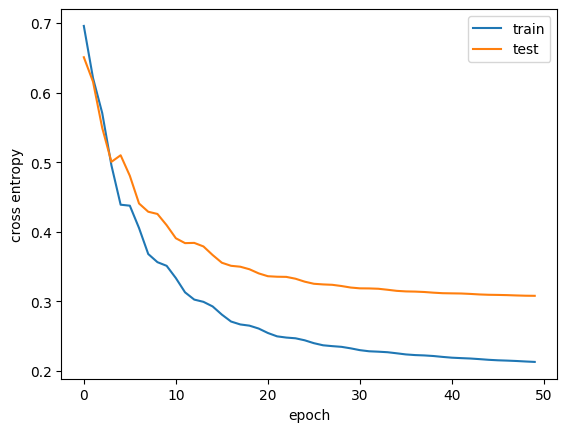

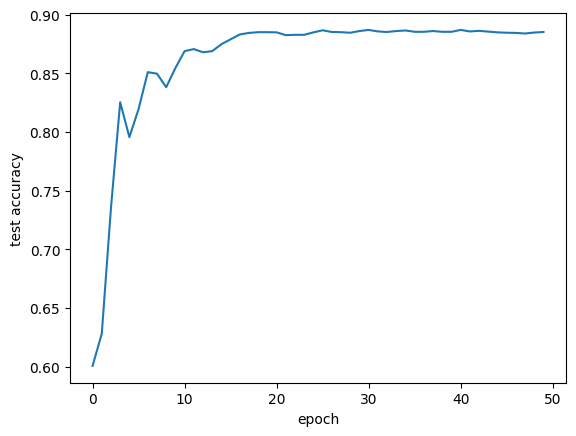

In [130]:
!pip install torcheval
from torcheval.metrics.functional import binary_accuracy
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

class LogisticRegression(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegression, self).__init__()
        # since we just have a binary classifier, we can get by with just 1
        # output dimension this makes computing the accuracy a bit more involved
        # than using argmax, which we solve using torcheval.
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        out = self.linear(x)
        return out

model = LogisticRegression(X_train_torch.shape[1]).to(device)
criterion = nn.BCEWithLogitsLoss()
# You can use SGD, but Adam converges quite fast.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

n_epochs = 50
train_losses = np.zeros((n_epochs,))
test_losses = np.zeros((n_epochs,))
test_accuracies = np.zeros((n_epochs,))

for n in range(n_epochs):
    # this is a good habit to get into (setting the model's mode to train). It
    # won't change anything for this model, but some model layers behave
    # differently when training versus test.
    model.train()
    optimizer.zero_grad()
    output = model(X_train_torch)
    loss = criterion(output, y_train_torch)
    train_losses[n] = loss.item()
    # this is like the ridge term in ridge regression.  It makes the weights
    # more interpretable (see below)
    l2_norm = sum(p.pow(2).sum() for p in model.parameters())
    loss = loss + 0.001 * l2_norm
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        model.eval()
        output = model(X_test_torch)
        loss = criterion(output, y_test_torch)
        test_losses[n] = loss.item()
        test_accuracies[n] = binary_accuracy(output.squeeze(), y_test_torch.squeeze(), threshold=0.0).item()

plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.xlabel('epoch')
plt.ylabel('cross entropy')
plt.legend()
plt.show()

plt.plot(test_accuracies)
plt.ylabel('test accuracy')
plt.xlabel('epoch')
plt.show()

For fun, we're also going to print out the words that contribute most to positive sentiment and negative sentiment.  We can do this by analyzing the weights directly.  The code is a bit involved, but hopefully our comments will help.

In [132]:
import numpy as np

# we are grabbing the weights.  We need to do a few conversions to get them in
# the right format.
feature_weights = model.linear.weight.data.cpu().numpy()[0]

# np.argsort gives us the indices that sort a list rather than the sorted list
# itself.  This is useful if we don't care about the weights but rather the
# feature indices.
print("Predictive of a bad review")
for idx in np.argsort(feature_weights)[:10]:
    print(vectorizer.get_feature_names_out()[idx])

print("Predictive of a good review")
# now we take the indices at the end rather than the beginning (high weights).
for idx in np.argsort(feature_weights)[-10:]:
    print(vectorizer.get_feature_names_out()[idx])

Predictive of a bad review
disappointment
waste
worst
disappointing
lacks
boring
awful
poorly
avoid
terrible
Predictive of a good review
enjoyed
rare
recommended
superb
stallone
gem
loved
refreshing
funniest
excellent


## tf-idf

## Notebook Exercise 3

As a last exercise, we want you to learn about the [tf-idf feature](https://en.wikipedia.org/wiki/Tf%E2%80%93idf).  The equations on the page are a bit daunting, but hopefully the ideas make sense.  Having the mental model from the IBM video regarding tf-idf may help (so maybe go watch the end of that video again).  If you find a great resource to learn about tf-idf, please let us know (there are many out there).  Also, bring your questions so we can debrief on this in class on Monday.

Adjust the code we gave you to compute the bag of words to instead use sklearn's `TfidfVectorizer` class.  You should just be able to modify the code slightly as shown below.

```
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

all_reviews = positive_reviews + negative_reviews
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(all_reviews)
```

How does the model performance change when using tf-idf instead of raw counts?  Can you make sense of this pattern.

### Toggle for Solution

We won't copy our whole solution code again, but the upshot is the performance doesn't change all that much (it may be a bit worse).  It seems the model is able to effectively handle the raw count data.  Maybe movie reviews are too similar in length for it to matter too much.  It's a bit hard to say without spending a bunch more time investigating.  We'd be excited to dig more into this with you.